In [1]:
import pandas as pd
import numpy as np
import time
import math
import re

from collections import defaultdict
from sklearn import svm, datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,TfidfTransformer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.externals import joblib



In [2]:
dev10 = pd.read_csv('./2019S1-proj2-datah_dos/dev-top100.csv')
train10 = pd.read_csv('./2019S1-proj2-datah_dos/train-top100.csv')
test10 = pd.read_csv('./2019S1-proj2-datah_dos/test-top100.csv')

In [3]:
test_raw = pd.read_csv("./2019S1-proj2-data_dos/test-raw.tsv",sep='\\t',header=None,engine='python')
test_raw=test_raw.rename(columns={0:'Instance_ID',1:'Location',2:'Text'})

In [4]:
train_raw = pd.read_csv("./2019S1-proj2-data_dos/train-raw.tsv",sep='\\t',header=None,engine='python')
dev_raw = pd.read_csv("./2019S1-proj2-data_dos/dev-raw.tsv",sep='\\t',header=None,engine='python')
train_raw=train_raw.rename(columns={0:'Instance_ID',1:'Location',2:'Text'})
dev_raw=dev_raw.rename(columns={0:'Instance_ID',1:'Location',2:'Text'})

In [5]:
corpus_train = train_raw['Text']
corpus_dev = dev_raw['Text']
corpus_test = test_raw['Text']

# countervectorizer and tf-idf

In [6]:
vectorizer = CountVectorizer()
count = vectorizer.fit_transform(corpus_train)  
transformer = TfidfTransformer()
tfidf = transformer.fit_transform(count) 

In [7]:
X_train=tfidf
y_train = train_raw['Location']
count_d = vectorizer.transform(corpus_dev)
tfidf_d = transformer.transform(count_d)
X_dev = tfidf_d
y_dev= dev_raw["Location"]

count_t = vectorizer.transform(corpus_test)
tfidf_t = transformer.transform(count_t)
X_test = tfidf_t

In [8]:
rcf = SGDClassifier(random_state=41, max_iter=500, tol=None, n_jobs=-1)

rcf.fit(X_train,y_train)
rcf.score(X_dev,y_dev)

0.3460177939757745

In [9]:
label = list(rcf.predict(X_test))

In [10]:
output=test_raw.copy()
#output['Location']=label
output=output.drop(['Text'],axis=1)

In [11]:
output.shape
#dev_raw=dev_raw.rename(columns={0:'Instance_ID',1:'Location',2:'Text'})

(108148, 2)

In [12]:
o1=output.copy()
o1 = o1.rename(columns={'Instance_ID':"Id","Location":"Class"})
o1.to_csv("predict_output.csv",index=False,sep=',')

# combine trainset and  devset

In [13]:
ntrain = pd.concat([train_raw['Text'],dev_raw['Text']],ignore_index=True)
ndev = pd.concat([y_train,y_dev],ignore_index = True)
vectorizer2 = CountVectorizer()
count2 = vectorizer2.fit_transform(ntrain)
transform2 = TfidfTransformer()
tfidf2 = transform2.fit_transform(count2)

In [14]:
xcount =  vectorizer2.transform(dev_raw["Text"])
xdev = transform2.transform(xcount) 

In [15]:
count3 = vectorizer2.transform(test_raw['Text'])
tfidf3 = transform2.transform(count3)
X_test = tfidf3

In [16]:
rcf2 = SGDClassifier(random_state=41, max_iter=500, tol=None, n_jobs=-1)
rcf2.fit(tfidf2,ndev)
label2= list(rcf2.predict(X_test))

In [17]:
rcf2.score(xdev,y_dev)

0.8580769643048558

In [18]:
o2 = o1.copy()
o2['Class'] = label2

In [19]:
o2.to_csv("predict_output2.csv",index=False,sep=',')

# cross validation

In [20]:
 from sklearn.model_selection import cross_val_score

In [23]:
scores = cross_val_score(rcf2, tfidf2, ndev, cv=5)
print('SGD cross-vali')
print("cv accuracy: ",  np.mean(scores))
print("cv stddev: ", np.std(scores))   

SGD cross-vali
cv accuracy:  0.48675717941427354
cv stddev:  0.034153378482722395


In [24]:
from sklearn.model_selection import learning_curve
from sklearn.svm import LinearSVC

In [25]:
x=tfidf2
y=ndev
estimator=rcf2
train_sizes=[0.1,0.2,0.4,0.6,0.7,0.8]

In [26]:
train_size,train_scores,test_scores=learning_curve(estimator,x,y,cv=10,train_sizes=[0.1,0.2,0.4,0.6,0.7,0.8],shuffle=True)
new_train_scores=train_scores.mean(1)
train_std=train_scores.std()
test_std=test_scores.std()
new_test_scores=test_scores.mean(1)

In [28]:
import matplotlib.pyplot as plt

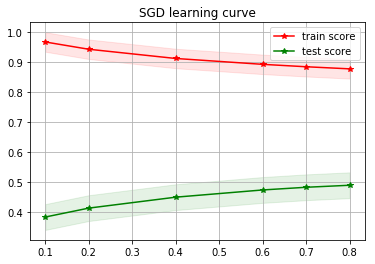

In [29]:
plt.grid()
plt.fill_between(train_sizes,new_train_scores-train_std,
                 new_train_scores+train_std,color='r',alpha=0.1)
plt.fill_between(train_sizes,new_test_scores-test_std,
                 new_test_scores+test_std,color='g',alpha=0.1)
 
plt.plot(train_sizes,new_train_scores,'*-',c='r',label='train score')
plt.plot(train_sizes,new_test_scores,'*-',c='g',label='test score')
plt.title("SGD learning curve")
plt.legend(loc='best')
plt.show()


# STEMMING

# # stem combine